## Import Libraries

In [1]:
# tokenizers
from tokenizers import Tokenizer, normalizers
from tokenizers.models import BPE, WordPiece, Unigram
from tokenizers.trainers import BpeTrainer, WordPieceTrainer, UnigramTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import NFD, StripAccents

# file management
import os
import glob
import pandas as pd

# evaluation
import time
import matplotlib.pyplot as plt

-------------
## Load Data (raw text)
1. get news
2. extract text
3. save extraction

In [2]:
# get news data
news_folder = '/workspaces/ner_news_malay/scraper/news'
parquet_files = glob.glob(os.path.join(news_folder, '*.parquet'))
print(f"found {len(parquet_files)} parquet files")

found 2 parquet files


In [3]:
# extract text from files
corpus_text = []
for file_path in parquet_files:
    try:
        df = pd.read_parquet(file_path)
        corpus_text.extend(df['Title'].dropna().str.lower().tolist())
        corpus_text.extend(df['Summary'].dropna().str.lower().tolist())
    except Exception as e:
        print(f"error processing {file_path}: {str(e)}")

In [4]:
# save corpus to text file
corpus_file = 'malay_news_corpus.txt'

with open(corpus_file, 'w', encoding='utf-8') as f:
    for text in corpus_text:
        f.write(text + '\n')
print(f"corpus size: {len(corpus_text)} sentences")

corpus size: 524 sentences


-------------
## Load Data (annotated text)
1. get annotated.json file
2. extract text
3. save extraction

---------
## Training
1. load algorithms
2. configure trainers
3. train tokenizers

In [5]:
# bpe
bpe_tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
bpe_tokenizer.normalizer = normalizers.Sequence([NFD(), StripAccents()])    # normalization
bpe_tokenizer.pre_tokenizer = Whitespace()                                  # remove whitespaces

# wordpiece
wp_tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
wp_tokenizer.normalizer = normalizers.Sequence([NFD(), StripAccents()])
wp_tokenizer.pre_tokenizer = Whitespace()

# unigram
uni_tokenizer = Tokenizer(Unigram())
uni_tokenizer.normalizer = normalizers.Sequence([NFD(), StripAccents()])
uni_tokenizer.pre_tokenizer = Whitespace()

In [6]:
# trainers
vocab_size = 30000
min_frequency = 2
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]

# bpe
bpe_trainer = BpeTrainer(
    vocab_size=vocab_size,
    min_frequency=min_frequency,
    special_tokens=special_tokens,
    show_progress=True
)

# wordpiece
wp_trainer = WordPieceTrainer(
    vocab_size=vocab_size,
    special_tokens=special_tokens,
    show_progress=True,
    continuing_subword_prefix="##"
)

# unigram
uni_trainer = UnigramTrainer(
    vocab_size=vocab_size,
    special_tokens=special_tokens,
    show_progress=True,
    unk_token="[UNK]"
)

In [7]:
# train tokenizers
tokenizer_folder = 'tokenizer_model'            # setup save folder
os.makedirs(tokenizer_folder, exist_ok=True)

tokenizers = {
    "bpe": (bpe_tokenizer, bpe_trainer),
    "wordpiece": (wp_tokenizer, wp_trainer),
    "unigram": (uni_tokenizer, uni_trainer)
}

for name, (tokenizer, trainer) in tokenizers.items():
    start_time = time.time()
    tokenizer.train(files=[corpus_file], trainer=trainer)   # change corpus_file to annotated_file
    training_time = time.time() - start_time

    # save tokenizer
    save_path = os.path.join(tokenizer_folder, f"malay_news_{name}_tokenizer.json")
    tokenizer.save(save_path)
    print(f"{name} training completed in {training_time:.2f} seconds")




bpe training completed in 0.08 seconds



wordpiece training completed in 0.09 seconds


unigram training completed in 0.03 seconds


-----------
## Evaluation
1. oov
2. speed
3. average tokens/sentence

In [8]:
test_sentences = [
    "harga minyak sawit meningkat 15% di pasaran antarabangsa bulan lalu",
    "kerajaan melancarkan inisiatif digital baharu dengan peruntukan rm500 juta",
    "apakah kesan teknologi blockchain terhadap industri kewangan malaysia?",
    "pendidikan stem menjadi keutamaan nasional mulai tahun 2025",
    "syarikat tempatan, abc sdn bhd, mencatatkan keuntungan rekod sebanyak rm2.4 bilion",
    "dr. ahmad zainuddin menjelaskan: 'inovasi penting untuk kemajuan negara'",
    "festival kebudayaan akan diadakan dari 15-20 ogos di pusat konvensi klcc",
    "pasukan bola sepak kebangsaan berjaya ke pusingan akhir setelah mengalahkan indonesia 3-1",
    "kajian menunjukkan 70% rakyat malaysia menyokong penggunaan tenaga boleh diperbaharui",
    "bagaimanakah implikasi kenaikan kadar faedah terhadap ekonomi domestik?"
]

results = {}
for name, (tokenizer, _) in tokenizers.items():
    # test sentences
    tokenizations = []
    for sentence in test_sentences:
        encoding = tokenizer.encode(sentence)
        tokenizations.append({
            "original": sentence,
            "tokens": encoding.tokens,
            "token_count": len(encoding.tokens)
        })

    # speed test
    start_time = time.time()
    with open(corpus_file, 'r', encoding='utf-8') as f:     # change corpus_file to annotated_file
        lines = f.readlines()[:1000]
        for line in lines:
            tokenizer.encode(line)
    speed = time.time() - start_time

    # average tokens
    sample_size = min(1000, len(corpus_text))               # change corpus_text to annotated_text
    total_tokens = 0
    total_words = 0

    for text in corpus_text[:sample_size]:                  # change corpus_text to annotated_text
        encoding = tokenizer.encode(text)
        total_tokens += len(encoding.tokens)    # per sentence
        total_words += len(text.split())        # per word

    avg_tokens_per_sentence = total_tokens / sample_size
    avg_tokens_per_word = total_tokens / total_words

    results[name] = {
        "tokenizations": tokenizations,
        "speed_sec": speed,
        "avg_tokens_per_sentence": avg_tokens_per_sentence,
        "avg_tokens_per_word": avg_tokens_per_word
    }

# display
for i, sentence in enumerate(test_sentences):
    print(f"\nsentence {i+1}: {sentence}")
    for algo in results:
        tokens = results[algo]['tokenizations'][i]['tokens']
        print(f"  {algo:<9}: {' '.join(tokens)}")


sentence 1: harga minyak sawit meningkat 15% di pasaran antarabangsa bulan lalu
  bpe      : harga minyak sa wi t meningkat 15 [UNK] di pasaran antarabangsa bulan lalu
  wordpiece: harga minyak sa ##w ##it meningkat 15 [UNK] di pasaran antarabangsa bulan lalu
  unigram  : harga mi nyak sa wi t meningkat 15 % di pasar an antara bangsa bulan lalu

sentence 2: kerajaan melancarkan inisiatif digital baharu dengan peruntukan rm500 juta
  bpe      : kerajaan me lan c arkan inisiatif digital baharu dengan peruntukan rm 500 juta
  wordpiece: kerajaan melancarkan inisiatif digital baharu dengan peruntukan rm500 juta
  unigram  : kera jaan mel an car kan ini sia tif di gi tal baharu dengan peruntuk an rm 500 jut a

sentence 3: apakah kesan teknologi blockchain terhadap industri kewangan malaysia?
  bpe      : a pak ah kesan tekn ologi b lo ck c ha in terhadap industri kewangan malaysia ?
  wordpiece: apa ##ka ##h kesan teknologi b ##lo ##c ##kc ##ha ##in terhadap industri kewangan malaysia ?
  

In [9]:
# number of sentences and number of words
print(f"number of sentences: {len(corpus_text)} sentences") # change corpus_text to annotated_text
print(f"number of words    : {total_words} words")

number of sentences: 524 sentences
number of words    : 10317 words


In [10]:
# comparing tokenizers
print(f"{'algorithm':<10} | {'speed (s)':<9} | {'avg tokens/sentence':<15}) | {'avg tokens/word':<10}")
for algo, res in results.items():
    print(f"{algo:<10} | {res['speed_sec']:.4f}    | {res['avg_tokens_per_sentence']:.2f}                | {res['avg_tokens_per_word']:.2f}")

algorithm  | speed (s) | avg tokens/sentence) | avg tokens/word
bpe        | 0.0229    | 26.27                | 1.33
wordpiece  | 0.0176    | 23.17                | 1.18
unigram    | 0.0405    | 42.22                | 2.14


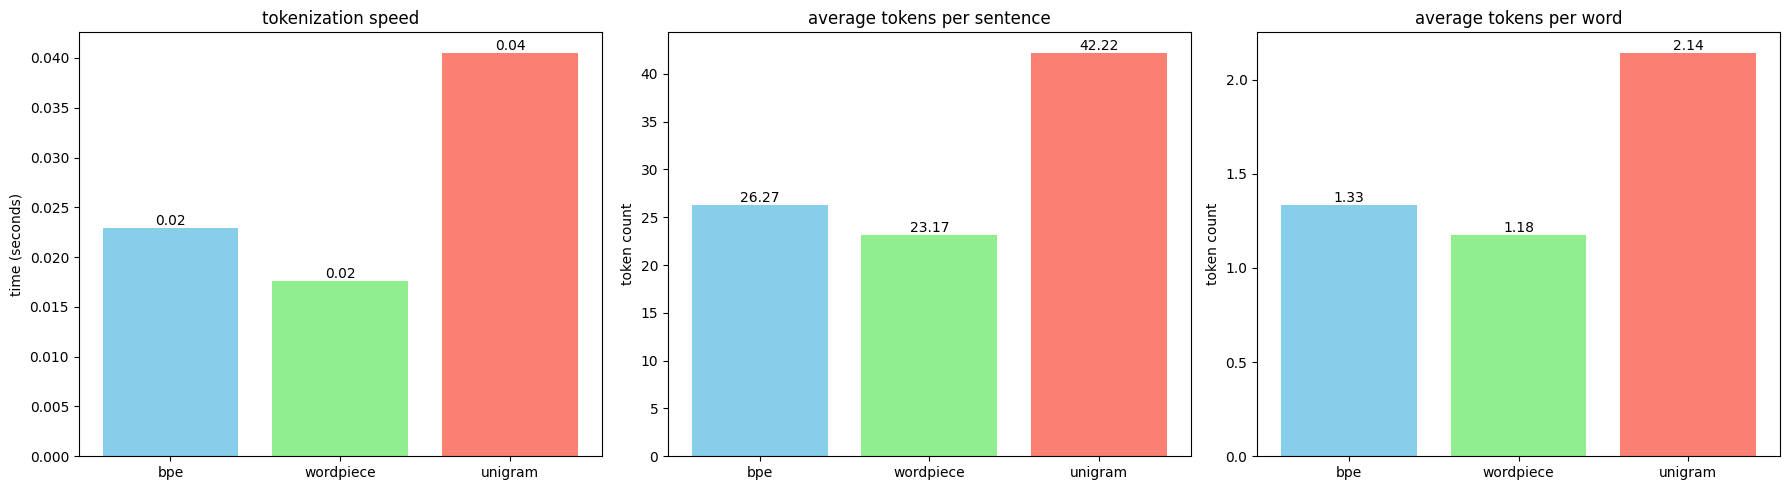

In [11]:
# visualization
plt.figure(figsize=(18, 5))

# speed
plt.subplot(1, 3, 1)
speeds = [results[algo]['speed_sec'] for algo in results]
plt.bar(results.keys(), speeds, color=['skyblue','lightgreen','salmon'])
plt.title('tokenization speed')
plt.ylabel('time (seconds)')
for i, v in enumerate(speeds):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')

# token efficiency
plt.subplot(1, 3, 2)
avg_tokens = [results[algo]['avg_tokens_per_sentence'] for algo in results]
plt.bar(results.keys(), avg_tokens, color=['skyblue','lightgreen','salmon'])
plt.title('average tokens per sentence')
plt.ylabel('token count')
for i, v in enumerate(avg_tokens):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')

# token efficiency
plt.subplot(1, 3, 3)
avg_tokens = [results[algo]['avg_tokens_per_word'] for algo in results]
plt.bar(results.keys(), avg_tokens, color=['skyblue','lightgreen','salmon'])
plt.title('average tokens per word')
plt.ylabel('token count')
for i, v in enumerate(avg_tokens):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')


# display
plt.tight_layout()
plt.show()

This analysis covers around 700 sentences with 15K words.
Based on these graphs, the WordPiece and BPE algorithms seems to be the best options to use for tokenizers. More data is needed for better readings.